In [1]:
import csv
import pandas as pd
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from pathlib import Path
import os
import time

In [2]:
def current_file_path():
    current_file = os.path.abspath(os.path.dirname(os.getcwd()))
    return current_file

# Data Storing Scripts

In [3]:
def generate_variable_name(params, **kwargs):
    """
    Generate a variable name dynamically based on the given parameters.
    Parameters:
    - params (dict): A dictionary containing 't' and 'theta_foldername' as keys.
    Returns:
    - str: The dynamically generated variable name.
    """
    t_value = params['t']
    u_value = params['u']
    if t_value != 0:
        t_formatted = "{:.1e}".format(t_value).replace("+", "").replace("e0", "e")
    else:
        t_formatted = "0e0"

    if u_value != 0:
        U_formatted = "{:.1e}".format(u_value).replace("+", "").replace("e0", "e")
    else:
        U_formatted = "0e0"
    theta_formatted = params['theta_foldername']
    return f"data_t{t_formatted}_U{U_formatted}_theta{theta_formatted}"

## HDF5 Files

In [4]:
def generate_unique_key(params, **kwargs):
    """
    Generate a unique key for the HDF5 dataset based on the provided parameters.

    Parameters:
    - params (dict): Dictionary containing 't' and 'u' values.
    - kwargs (dict): Dictionary of additional key-value pairs for key generation.

    Returns:
    - str: The formatted unique key.
    """
    t_value = params['t']
    u_value = params['u']

    if t_value != 0:
        t_formatted = "{:.1e}".format(t_value).replace("+", "").replace(".", "_").replace("e0", "e").replace("-", "")
    else:
        t_formatted = "0e0"

    if u_value != 0:
        U_formatted = "{:.1e}".format(u_value).replace("+", "").replace(".", "_").replace("e0", "e").replace("-", "")
    else:
        U_formatted = "0e0"

    if 'std_deviation_numberOp' in kwargs:
        key = f"std_deviation_numberOp_U{U_formatted}_t{t_formatted}"
    elif 'exp_nOp' in kwargs:
        key = f"expnOp_U{U_formatted}_t{t_formatted}"
    elif 'gndstate_energy' in kwargs:
        key = f"gndenergy_U{U_formatted}_t{t_formatted}"
    elif 'firstexcitedenergy' in kwargs:
        key = f"firstexcitedenergy_U{U_formatted}_t{t_formatted}"
    return key


In [5]:
def generating_complete_path_hdf5(filename, **kwargs):
    current_file = current_file_path()
    if params['theta_foldername'] == '0':
        if 'Correlation' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta{params['theta_foldername']}', f'L{params['L']}','Correl_matrix',filename)
        elif 'entropy' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta{params['theta_foldername']}', f'L{params['L']}','Entropy',filename)
        elif 'expnop' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta{params['theta_foldername']}', f'L{params['L']}','Exp_nOp',filename)
        else:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta{params['theta_foldername']}', f'L{params['L']}','Remainig_Data',filename)
    else:
        if 'Correlation' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta_{params['theta_foldername']}', f'L{params['L']}','Correl_matrix',filename)
        elif 'entropy' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta_{params['theta_foldername']}', f'L{params['L']}','Entropy',filename)
        elif 'expnop' in kwargs:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta_{params['theta_foldername']}', f'L{params['L']}','Exp_nOp',filename)
        else:
            complete_path = os.path.join(current_file, 'AHM_Data_Codes', f'theta_{params['theta_foldername']}', f'L{params['L']}','Remainig_Data',filename)
    return complete_path

In [6]:
def create_folders_and_store_data(params, data, filename, **kwargs):
    """
    Create folders dynamically based on theta and L values, and store data in a file.
    Writes data - overwrite if file already exists
    Parameters:
    - theta (float or str): The value of theta (e.g., 0, pi/4, pi/2, etc.).
    - L (int): The integer value of L.
    - data (DataFrame): The data to be stored.
    - filename (str): The name of the file to store data in.
    """
    # Define the base directory
    if params['theta_foldername'] == '0':
        if 'Correlation' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Correl_matrix'
        elif 'entropy' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Entropy'
        elif 'expnop' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Exp_nOp'
        else:      
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Remainig_Data'
    else:
        if 'Correlation' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Correl_matrix'
        elif 'entropy' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Entropy'
        elif 'expnop' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Exp_nOp'
        else:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Remainig_Data'
    # Create directories if they don't exist
    base_dir.mkdir(parents=True, exist_ok=True)
    # Define the full file path
    file_path = base_dir / filename
    # Writing the data to a HDF5 file in the created directory
    data.to_hdf(file_path, key=kwargs['key'], mode='w')

# filename = 'testing.csv'
# data=  pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
# key = 'testing'
# params['L'] = 10
# params['theta_foldername'] = '0'
# create_folders_and_store_data(params, data, filename, key = key, Entropy = True)

In [7]:
def write_data_to_hdf5(params, data, file_name, **kwargs):
    """
    This is useful only when the folder exists and you want to create new hdf5 file.
    Write a single dataset to an HDF5 file under a specified key.
    Parameters:
    - file_name (str): The name of the HDF5 file.
    - data (pd.DataFrame or pd.Series): The data to write to the HDF5 file.
    - key (str): The key under which the data will be stored in the HDF5 file.
    """
    data.to_hdf(file_name, key=kwargs['key'], mode='a', format='table')

In [8]:
def generate_file_name_hdf5(params, **kwargs):
    """
    Generate a file name dynamically based on the given parameters.
    Parameters:
    - params (dict): A dictionary containing 'L', 'nmax', and 't' as keys.
    Returns:
    - str: The dynamically generated file name.
    """
    # Format the 't' value to scientific notation if needed
    t_value = params['t']
    u_value = params['u']
    
    if t_value != 0:
        t_formatted = "{:.1e}".format(t_value).replace("+", "").replace("e0", "e")
    else:
        t_formatted = "0e0"

    if u_value != 0:
        U_formatted = "{:.1e}".format(u_value).replace("+", "").replace("e0", "e")
    else:
        U_formatted = "0e0"

    if 'Correlation' in kwargs:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}_CorrelationMatrix.h5"
    elif 'entropy' in kwargs:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}_entropy.h5"
    elif 'expnop' in kwargs:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}_expnop.h5"
    else:
        file_name = f"L{params['L']}_t{t_formatted}_Nmax{params['NB_MAX']}_Nbosons{params['N_BOSON']}_U{U_formatted}.h5"
    return file_name


In [9]:
def load_matrix_from_hdf5(filepath, **kwargs):
    """
    Load a matrix from an HDF5 file using pandas.
    Parameters:
    - filepath (str or Path): The path to the HDF5 file.
    - key (str): The key to the dataset to load (default is 'correlation_matrix').
    Returns:
    - ndarray: The matrix loaded from the HDF5 file as a NumPy array.
    """
    df = pd.read_hdf(filepath, key=kwargs['key'])
    return df.values  # Convert the DataFrame to a NumPy array


In [10]:
def append_data_to_hdf5(params, data, filename, **kwargs):
    """
    Create folders dynamically based on theta and L values, and append data to an HDF5 file.
    
    If the file does not exist, it will be created. If it does exist, the data will be appended.

    Parameters:
    - theta (float or str): The value of theta (e.g., 0, pi/4, pi/2, etc.).
    - L (int): The integer value of L.
    - data (DataFrame or Series): The data to append.
    - filename (str): The name of the HDF5 file to store/append data.
    - key (str): The key under which the data is stored in the HDF5 file.
    """
    # Define the base directory
    if params['theta_foldername'] == '0':
        if 'Correlation' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Correl_matrix'
        elif 'entropy' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Entropy'
        elif 'expnop' in kwargs:
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Exp_nOp'
        else:      
            base_dir = Path.cwd() / f"theta{params['theta_foldername']}" / f"L{params['L']}" / 'Remainig_Data'
    else:
        if 'Correlation' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Correl_matrix'
        elif 'entropy' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Entropy'
        elif 'expnop' in kwargs:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Exp_nOp'
        else:
            base_dir = Path.cwd() / f"theta_{params['theta_foldername']}" / f"L{params['L']}" / 'Remainig_Data'
    
    base_dir.mkdir(parents=True, exist_ok=True)
    file_path = base_dir / filename
    # Append the data to the HDF5 file (create the file if it doesn't exist)
    data.to_hdf(file_path, key=kwargs['key'], mode='a', index=False, append=True)

# Data for a $\theta$, $L$, $N\_{Boson}$, $N\_{Max}$, $U$

In [11]:
params={}
params['L'], params['N_BOSON'] = 20, 20
params['theta_foldername_list'] = ['0', 'Piby4', 'Piby2', '3Piby4', 'Pi']
params['theta'], params['theta_foldername'] = np.pi, params['theta_foldername_list'][4]
params['t'] = 1
params['u'] = 1
params['mu'] = 0
params['NB_MAX'] = 3 # max n_boson per site
params['theta_list'] = [0, np.pi/4, 3*np.pi/4, np.pi/2, np.pi]
params['t_list'] = np.arange(0.01, 2, 0.1)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny|SymmetryTypes.CPX, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [12]:
site_basis, site_ops = [], []
for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['NB_MAX'] + 1)] 
    ops = {
        "": np.identity(params['NB_MAX'] + 1),                           # identity
        "C": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1)), k=-1), # b+
        "D": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1)), k=1),  # b
        "N": np.diag(np.arange(0, params['NB_MAX'] + 1), k=0),           # particle number
        "A": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1))*np.exp(1j * params['theta'] * np.arange(params['NB_MAX'])), k=-1), # A+_withPhase  
        "B": np.diag(np.sqrt(np.arange(1, params['NB_MAX'] + 1))*np.exp(-1j * params['theta'] * np.arange(params['NB_MAX'])), k=1), # A_withPhase  
    }
    site_basis.append(basis)
    site_ops.append(ops)

## First Excited Gap, Correlation, Number Operator and Entropy Data

#### $U = 0$

In [254]:
start_time = time.time()
#########################################

params['u'] = 0
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 862.17 seconds


In [255]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

##### Testing of Correlation Matrix by plotting it

In [ ]:
theta_values = [0]
L_values = [10]

example_data = pd.DataFrame({
    'Column1': np.random.rand(10),
    'Column2': np.random.rand(10)
})

for theta in theta_values:
    for L in L_values:
        filename = generate_file_name_hdf5(params)
        create_folders_and_store_data(params, example_data, filename)

In [47]:
filename = generate_file_name_hdf5(params, Correlation = True)

In [50]:
current_file = os.path.abspath(os.path.dirname(os.getcwd()))
filename1 = os.path.join(current_file, 'AHM_Data_Codes', 'theta0', f'L{10}', filename)

In [54]:
hop_exp_val1 = load_matrix_from_hdf5(filename1, key = 'data')

In [57]:
hop_exp_val1 = np.power(np.abs(hop_exp_val1), 2)
plt.imshow(hop_exp_val1, cmap="Blues")

##### Some Minor Testing of Scaling Laws

In [9]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

In [30]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

In [33]:
params['t'] = 0
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [19]:
print(kets[0])
print(entropy1)

[-8.88178420e-16 -8.88178420e-16 -8.88178420e-16 -8.88178420e-16
 -8.88178420e-16 -8.88139235e-16  2.63409891e-10  1.22678750e-10
  8.13411184e-11]


In [20]:
entropy2 = driver.get_bipartite_entanglement(kets[1])
print(entropy2)

[0.00000000e+000 3.41084312e-162 1.30021674e-078 9.50087542e-047
 1.20819030e-014 9.63085519e-012 3.28992598e-002 7.32875617e-001
 8.51719905e-001]


In [29]:
df = pd.read_csv("theta0_AHMDmrg_data.csv")
params['t'] = 0
condition = df['t'] == params['t']
df.loc[condition, 'Entropy'] = str(entropy1) * condition.sum()

# Step 4: Save the updated DataFrame back to the CSV file
df.to_csv("theta0_AHMDmrg_data.csv", index=False)


In [27]:
df.to_pickle("dataframe.pkl")

[-8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.8817842e-16, -8.88139235e-16, 2.63409891e-10, 1.2267875e-10, 8.13411184e-11]


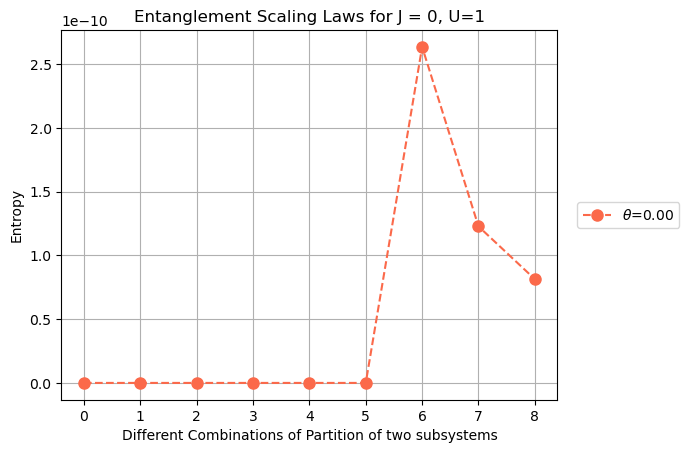

In [28]:
def convert_stringlist_to_float_list(string):
    # Remove the square brackets and split by spaces
    float_list = list(map(float, string.strip('[]').split()))
    return float_list

def get_data_by_conditions(df, conditions, columns):
    condition = pd.Series([True] * len(df)) 
    for key, value in conditions.items():
        condition &= df[key] == value
    filtered_df = df[condition]
    return filtered_df[columns] if not filtered_df.empty else None
colors1 = plt.cm.Reds(np.linspace(0.5, 0.95, len(params['theta_list'])))
conditions = {'t': 0} 
keywords = ['Entropy']
result = get_data_by_conditions(df, conditions, keywords)
entropy = convert_stringlist_to_float_list(result.values[0][0])
print(entropy)
plt.plot(list(range(len(entropy))), entropy, "--o", label=f'$θ$={params['theta_list'][0]:.2f}', color = colors1[0], ms=8)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.xlabel('Different Combinations of Partition of two subsystems')
plt.ylabel('Entropy')
U, t = params['u'], 0
plt.title(f'Entanglement Scaling Laws for J = {t}, U={U}')
plt.grid(True)
plt.show() 

#### $U = 0.1$

In [273]:
start_time = time.time()
#########################################

params['u'] = 0.1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 863.51 seconds


In [274]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

##### Correlation Rate

In [ ]:
middle_index = (params['L'] - 1) // 2
correlation_rate = hop_exp_val[middle_index, :]

In [ ]:
correl_rate = pd.DataFrame(correlation_rate)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, filename, correlation_rate, key = 'correl_rate')

#### $U = 0.2$

In [288]:
start_time = time.time()
#########################################

params['u'] = 0.2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 800.36 seconds


In [289]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.3$

In [81]:
start_time = time.time()
#########################################

params['u'] = 0.3
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 220.28 seconds


In [82]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.4$

In [90]:
start_time = time.time()
#########################################

params['u'] = 0.4
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 194.88 seconds


In [91]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.5$

In [100]:
start_time = time.time()
#########################################

params['u'] = 0.5
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 137.12 seconds


In [101]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.6$

In [109]:
start_time = time.time()
#########################################

params['u'] = 0.6
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 121.44 seconds


In [110]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.7$

In [119]:
start_time = time.time()
#########################################

params['u'] = 0.7
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 184.42 seconds


In [120]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.8$

In [128]:
start_time = time.time()
#########################################

params['u'] = 0.8
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 213.31 seconds


In [129]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 0.9$

In [137]:
start_time = time.time()
#########################################

params['u'] = 0.9
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 114.74 seconds


In [138]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 1.0$

In [147]:
start_time = time.time()
#########################################

params['u'] = 1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 117.29 seconds


In [148]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 1.1$

In [157]:
start_time = time.time()
#########################################

params['t'] = 1.1
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 143.49 seconds


In [158]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [ ]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
## Complete path
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, gndstate_energy = True)
## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)

In [ ]:
## Testing
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

##### Entropy

In [ ]:
entropy1 = driver.get_bipartite_entanglement(kets[0])

###### HDF5 Files

In [ ]:
entropy = pd.DataFrame(entropy1)
filename = generate_file_name_hdf5(params, entropy = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, entropy = True)
create_folders_and_store_data(params, entropy, filename, key = 'entropy', entropy = True)

##### Correlation Matrix

In [ ]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [ ]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, Correlation = True)
## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, correl_matrix, filename1, key = 'correl_matrix', Correlation = True)

##### NumberOperator and Its Standard Deviation

In [ ]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [ ]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

In [ ]:
# key = generate_unique_key(params, exp_nOp = True)
# density_nop = load_matrix_from_hdf5(filename1, key = key)
# print(density_nop)

###### Standard Deviation

In [ ]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
# create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

In [ ]:
key = generate_unique_key(params, std_deviation_numberOp = True)
std_nop = load_matrix_from_hdf5(filename1, key = key)
print(std_nop[0][0])

In [ ]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

#### $U = 1.2$

In [167]:
start_time = time.time()
#########################################

params['t'] = 1.2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 130.75 seconds


In [168]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.3$

In [176]:
start_time = time.time()
#########################################


params['u'] = 1.3
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 145.98 seconds


In [177]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.4$

In [187]:
start_time = time.time()
#########################################

params['u'] = 1.4
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 101.90 seconds


In [188]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.5$

In [196]:
start_time = time.time()
#########################################

params['u'] = 1.5
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 106.02 seconds


In [197]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.6$

In [205]:
start_time = time.time()
#########################################


params['u'] = 1.6
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 115.74 seconds


In [206]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.7$

In [216]:
start_time = time.time()
#########################################


params['u'] = 1.7
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 109.30 seconds


In [217]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.8$

In [225]:
start_time = time.time()
#########################################

params['u'] = 1.8
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 95.94 seconds


In [226]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 1.9$

In [234]:
start_time = time.time()
#########################################

params['u'] = 1.9
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 96.02 seconds


In [235]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')

#### $U = 2.0$

In [243]:
start_time = time.time()
#########################################

params['u'] = 2
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N_BOSON']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# b.add_term("ADCB", np.array([[i, i+1, i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("AD", np.array([[i, i+1] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("CB", np.array([[i+1, i] for i in range(params['L']-1)]).flatten(), -params['t'])
b.add_term("N", np.array(np.arange(params['L'])), -(params['mu'] + params['u'] / 2))
b.add_term("NN", np.repeat(np.arange(params['L']), 2), params['u'] / 2)

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=2)
energy = driver.dmrg(mpo, mps, n_sweeps=10, bond_dims=[50] * 4 + [100] * 4,
    noises=[1e-4] * 4 + [1e-5] * 4 + [0], thrds=[1e-10] * 8, dav_max_iter=30, iprint=0)

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 115.35 seconds


In [244]:
kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

##### First Excitation Gap

In [172]:
key = generate_unique_key(params, gndstate_energy = True)
print(key)

gndenergy_U1_0e0_t1_2e0


In [173]:
gndenergy = pd.DataFrame({'gndenergy':[np.power(np.abs(energy[1]-energy[0]),2)]})
filename = generate_file_name_hdf5(params)
# print(filename)
filename1 = generating_complete_path_hdf5(filename)
# print(filename1)
key = generate_unique_key(params, gndstate_energy = True)
print(key)

## Use the code below to append data to an existing file/folder directory
append_data_to_hdf5(params, gndenergy, filename1, key = key)


gndenergy_U1_0e0_t1_2e0


In [174]:
gndenergy = load_matrix_from_hdf5(filename1, key = key)
print(gndenergy[0][0])

0.06264391408627396


In [175]:
with pd.HDFStore(filename1, 'r') as hdf:
    # List all keys in the file
    keys = hdf.keys()
    print("Keys in HDF5 file:")
    for key in keys:
        print(key)

Keys in HDF5 file:
/gndenergy_U1_0e0_t1_2e0
/std_deviation_numberOp_U1_0e0_t1_2e0


##### Entropy

In [62]:
entropy1 = driver.get_bipartite_entanglement(kets[0])
update_csv_column("theta0_AHMDmrg_data.csv", 'Entropy', 't', params['t'], str(entropy1))

In [ ]:
#### Data Storing
data_t1_2_theta0 = [[params['L'], params['t'], params['u'], params['N_BOSON'], params['NB_MAX'], energy[0], mps, energy[1], entropy]]
add_data_to_csv("theta0_AHMDmrg_data.csv", data_t1_2_theta0)

##### NumberOperator and Its Standard Deviation

In [169]:
std_val, std_nOp = 0, 0
_exp_nop = []
for i in range(params['L']):
    b = driver.expr_builder()
    b.add_term("N", np.array([i]), 1)
## Calculate <N>   
    nOp_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    impo = driver.get_identity_mpo()

    nOp_exp = driver.expectation(kets[0], nOp_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0])
    _exp_nop.append(nOp_exp)
## Calculate <N^2>
    b = driver.expr_builder()
    b.add_term("NN", np.repeat([i], 2), 1)
    
    NN_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
    NN_exp = driver.expectation(kets[0], NN_mpo, kets[0]) / driver.expectation(kets[0], impo, kets[0]) 
## Calculate Standard Deviation
    std_val+=np.sqrt(NN_exp - (nOp_exp*nOp_exp))        
std_nOp = (std_val/params['L'])

###### Expectation value of Number Operator on each site

In [170]:
density_nop = pd.DataFrame(_exp_nop)
filename = generate_file_name_hdf5(params, expnop = True)
## Complete path of the location of the file
filename1 = generating_complete_path_hdf5(filename, expnop = True)
key = generate_unique_key(params, exp_nOp = True)
create_folders_and_store_data(params, density_nop, filename, key = key, expnop = True)

###### Standard Deviation

In [171]:
std_deviation_numberOp = pd.DataFrame({'std_nOp':[std_nOp]})
filename = generate_file_name_hdf5(params)
filename1 = generating_complete_path_hdf5(filename)
key = generate_unique_key(params, std_deviation_numberOp = True)

## Use the code below to append data to an existing file/folder directory
# append_data_to_hdf5(params, std_deviation_numberOp, filename1, key = key)

####### Use this only for the first time when taking data for a theta #######
## Use this code to write data to a new file irrespective of the presence of subholder based on 'L'.
create_folders_and_store_data(params, std_deviation_numberOp, filename, key = key)

##### Correlation Matrix and Rate

In [418]:
hop_exp_val = np.zeros((params['L'], params['L']), dtype=complex)
for i in range(params['L']):
    for j in range(i, params['L']):
        b = driver.expr_builder()
        b.add_term("CD", np.array([i, j]), 1)  # Hopping operator between i and j            
        hop_mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)
        hop_exp_val[i, j] = driver.expectation(kets[0], hop_mpo, kets[0])
        hop_exp_val[j, i] = np.conjugate(hop_exp_val[i, j])

In [419]:
correl_matrix = pd.DataFrame(hop_exp_val)
filename = generate_file_name_hdf5(params, Correlation = True)
create_folders_and_store_data(params, correl_matrix, filename, key = 'correl_matrix')